# Introduction
In this notebook we analyze the data and construct multiclass classification models for the Albert Einstein Hospital's data science case.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [123]:
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import cycle
from matplotlib import cm
from matplotlib import pyplot as plt

# sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
import shap

In [7]:
%matplotlib inline

# Load Data

In [10]:
%%time
data = pd.read_csv('../data/df_data.csv')

CPU times: user 5.08 ms, sys: 2.16 ms, total: 7.24 ms
Wall time: 6.9 ms


# Auxiliary functions

In [11]:
def autolabel(rects, ax):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height*100:.2f}%',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize = 8)

In [12]:
def compute_roc_auc_classes(y_true, y_probas):
    '''Computes the fpr (false positive rate), tpr (true positive rate)
    and roc_auc score for the case of multiclass classification. 
    Parameters:
    -----------
    y_true: pd.DataFrame,
            target true values with class labels as columns
    y_probas: array,
            output of the classifier `predict_proba` or the `decision_function` methods.
    Returns:
    --------
    fpr: dictionary of False Positive rates,
            keys: classes.
            values: False Positive rates.
    tpr: dictionary of True Positive rates,
            keys: classes.
            values: False Positive rates.
    roc_auc: dictionary holding ROC AUC score for each class,
            keys: classes.
            values: ROC AUC scores.
        
    '''
    classes = y_true.columns.to_list()
    # Compute ROC_AUC for each class
    fpr = {class_ : None for class_ in classes}
    tpr = {class_ : None for class_ in classes}
    roc_auc = {class_ : None for class_ in classes}
    for i, class_ in enumerate(classes):
        fpr[class_], tpr[class_], _ = roc_curve(y_true[class_], y_probas[:, i])
        roc_auc[class_] = auc(fpr[class_], tpr[class_])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.values.ravel(), y_probas.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[class_] for class_ in classes]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for class_ in classes:
        mean_tpr += np.interp(all_fpr, fpr[class_], tpr[class_])


    # Finally average it and compute AUC
    mean_tpr /= len(classes)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return fpr, tpr, roc_auc

In [121]:
def compute_precision_recall_classes(y_true, y_probas):
    '''Computes the fpr (false positive rate), tpr (true positive rate)
    and roc_auc score for the case of multiclass classification. 
    Parameters:
    -----------
    y_true: pd.DataFrame,
            target true values with class labels as columns
    y_probas: array,
            output of the classifier `predict_proba` or the `decision_function` methods.
    Returns:
    --------
    precision: dictionary of precisions,
            keys: classes.
            values: precision values for each threshold.
    recall: dictionary of recalls,
            keys: classes.
            values: recall values for each threshold.
    average_precision: dictionary holding average precision score for each class,
            keys: classes.
            values: average precision scores.
        
    '''
    classes = y_true.columns.to_list()
    # Compute precision recall for each class
    precision = {class_ : None for class_ in classes}
    recall = {class_ : None for class_ in classes}
    average_precision = {class_ : None for class_ in classes}
    for i, class_ in enumerate(classes):
        precision[class_], recall[class_], _ = precision_recall_curve(y_true[class_], y_probas[:, i])
        average_precision[class_] = average_precision_score(y_true[class_], y_probas[:, i])
    # Compute micro-average precision recall curve and micro average precision
    precision["micro"], recall["micro"], _ = roc_curve(y_true.values.ravel(), y_probas.ravel())
    average_precision["micro"] = average_precision_score(y_true.values.ravel(), y_probas.ravel(), 
                                                         average = 'micro')
    
    return precision, recall, average_precision

In [150]:
def plot_roc_auc_classes(fpr, tpr, roc_auc,
                         micro = True, macro = True, 
                         ax = None, **kwargs):
    '''Given the output of the `compute_roc_auc_classes` function, it plots
    the corresponding ROC curves for each clases and micro/macro averages
    Parameters:
    ----------
    fpr: dictionary of False Positive rates,
            keys: classes.
            values: False Positive rates.
    tpr: dictionary of True Positive rates,
            keys: classes.
            values: False Positive rates.
    roc_auc: dictionary holding ROC AUC score for each class,
            keys: classes.
            values: ROC AUC scores.
    micro: Boolean (default = True),
            whether to plot the micro averaged quantities
    macro: Boolean (default = True)
            whether to plot the macro averaged quantities
    ax: matplotlib axis object (default = None)
            
    Returns:
    --------
    ax: matplotlib axis object
    '''
    if ax == None:
        f, ax = plt.subplots(dpi = 120, figsize = (7,6))
    if micro == True:
        ax.plot(fpr["micro"], tpr["micro"],
                 label= f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
                 color='deeppink', linestyle=':', linewidth=4)
    if macro == True:
        ax.plot(fpr["macro"], tpr["macro"],
             label = f'macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
             color = 'navy', linestyle=':', linewidth=4)
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for class_, color in zip(classes, colors):
        ax.plot(fpr[class_], tpr[class_], color=color, lw=lw,
                 label = f'ROC curve of class {class_} (area = {roc_auc[class_]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC AUC')
    ax.legend(loc="lower right", fontsize = kwargs['fontsize'])
    return ax

In [154]:
def plot_precision_recall_curve(precision, recall, average_precision, 
                                micro = True, ax = None, **kwargs):
    '''Given the output of the function `compute_precision_recall_classes` it plots the corresponding
    precision-recall curves.
    Parameters:
    -----------
    precision: dictionary of precisions,
            keys: classes.
            values: precision values for each threshold.
    recall: dictionary of recalls,
            keys: classes.
            values: recall values for each threshold.
    average_precision: dictionary holding average precision score for each class,
            keys: classes.
            values: average precision scores.
    micro: Boolean (default = True)
            whether to plot the micro averaged precision-recall curve
    ax: matplotlib axis object (default = None)
    
    Returns:
    --------
    ax: matplotlib axis object
    '''
    colors = cycle(['navy', 'turquoise', 'darkorange'])
    if ax == None:
        f, ax = plt.subplots(figsize=(7, 5), dpi = 120)
    if micro == True:
        ax.plot(recall["micro"], precision["micro"], color='gold', lw=2, 
                label = f'micro-average Precision-recall (area = {average_precision["micro"]:.2f})')

    for class_, color in zip(classes, colors):
        ax.plot(recall[class_], precision[class_], color=color, lw=2,
                label = f"Precision-recall for class {class_} (area = {average_precision[class_]:.2f})")
    ax.legend(loc = 'best', fontsize = kwargs['fontsize'])
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall curve')
    return ax

# EDA
In this section we perform an exploratory data analysis in order to try to understand the nature of the problem as well as of the nature of the variables. As the following lines show, we are dealing with a *three class* classification problem for which we have three features at hand. 

In [13]:
data.head()

,x1,x2,x3,target
0,2.71,10.39,-36.45,med
1,9.88,5.76,-54.63,med
2,82.87,1.73,0.83,med
3,12.99,10.40,-59.60,med
4,60.10,8.84,-45.87,med


In [14]:
data.describe()

,x1,x2,x3
count,10000.000000,10000.000000,10000.000000
mean,42.669613,9.023236,-24.603198
std,25.597848,5.180151,20.138584
min,-19.500000,0.170000,-59.980000
25%,21.675000,5.260000,-41.920000
50%,42.940000,8.075000,-24.555000
75%,64.135000,11.730000,-7.080000
max,101.520000,43.080000,9.990000


In [15]:
data.isna().sum()

x1        0
x2        0
x3        0
target    0
dtype: int64

## Class prior probability Distributions
To gain intuition about the problem, let us look at the prior probabilities for the classes (target). This is, we want to see if the events are equally likely or if there is an unbalance in the probabilities for each class.

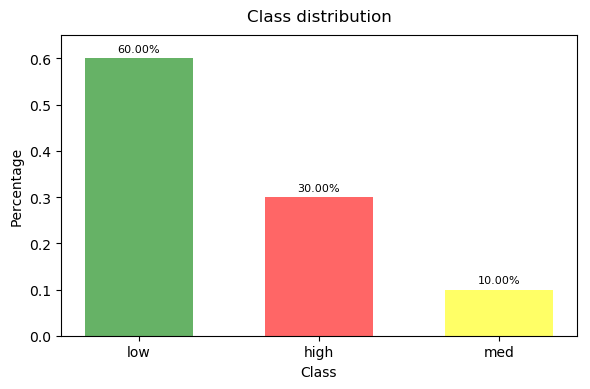

In [16]:
fig, ax = plt.subplots(dpi = 100)
bars = data.target.value_counts(normalize = True).to_dict()
x = np.arange(len(bars.keys()))
colors = ['green', 'red', 'yellow']
rects = ax.bar(x, height = list(bars.values()), width = 0.6, color = colors, alpha = 0.6)
ax.set_xticks(x)
ax.set_xticklabels(bars.keys())
ax.set_ylim(0, 0.65)
autolabel(rects, ax)
ax.set_ylabel('Percentage')
ax.set_xlabel('Class')
ax.set_title('Class distribution', y = 1.02)
fig.tight_layout()

The above figure shows the distribution of classes. In this case we are dealing with an unbalanced dataset, where there are more examples (60%) of the so called *low* class. The name of the features suggest the target might be related to some kind of risk, e.g. the risk of having a *heart attack*.

## Feature space exploration
There are three features in the dataset, the fact that the are anonimized difficults their interpreation and the use of any prior domain knowledge. Therefore, we briefly explore the feature space to see if there are patterns that might be easy to recognize at first sight.

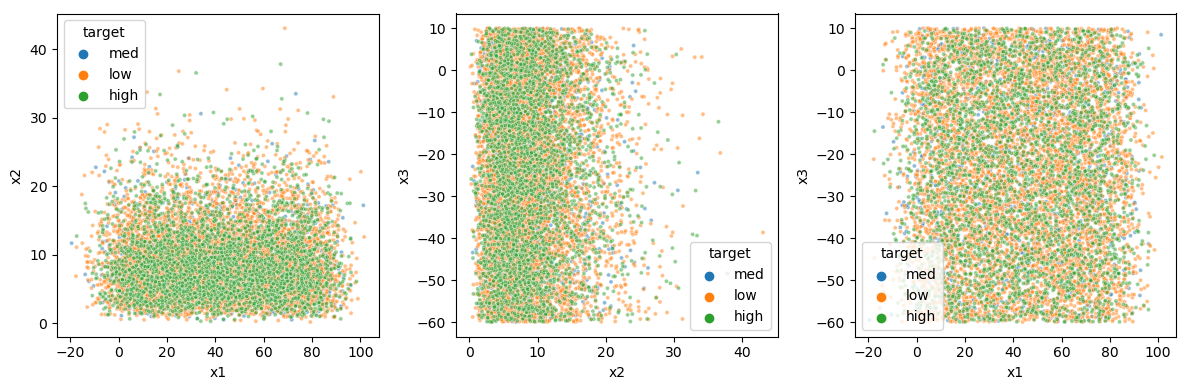

In [17]:
fig, ax = plt.subplots(1, 3, dpi = 100, figsize = (12,4))

sns.scatterplot(data = data, x = f'x1', y = f'x2', 
                    marker = '.', alpha = 0.5, hue = 'target',
                    ax = ax[0])
sns.scatterplot(data = data, x = f'x2', y = f'x3', 
                    marker = '.', alpha = 0.5, hue = 'target',
                    ax = ax[1])
sns.scatterplot(data = data, x = f'x1', y = f'x3', 
                    marker = '.', alpha = 0.5, hue = 'target',
                    ax = ax[2])
fig.tight_layout()

No obvious patter can be recognized in the above figures. The features appear to be random variables drawn from some, at first, unknown probability distributions.

## Feature prior and conditional probabilities
We can also try to estimate the probability distributions by plotting the histograms (frequency of values) for each feature. This could give us some additional information about the nature of each variable.

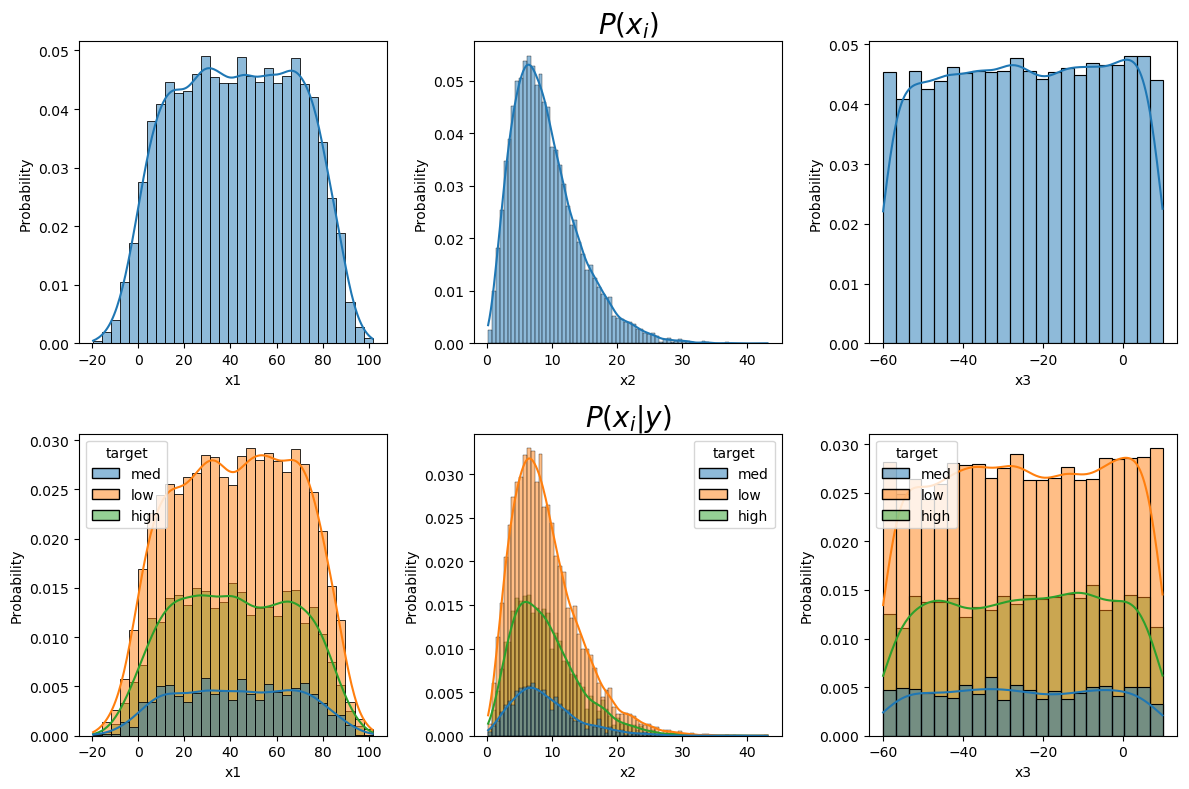

In [18]:
fig, ax = plt.subplots(2, 3, dpi = 100, figsize = (12,8))
for feature, axis in zip([x for x in data.columns if x.startswith('x')], ax[0]):
    sns.histplot(data[feature], kde= True, stat= 'probability', ax = axis)
ax[0][1].set_title(r'$P(x_i)$', fontsize = 20)
for feature, axis in zip([x for x in data.columns if x.startswith('x')], ax[1]):
    sns.histplot(data, x = feature, hue = 'target', stat= 'probability', kde= True, ax = axis)
ax[1][1].set_title(r'$P(x_i | y)$', fontsize = 20)
    
fig.tight_layout()

The bottom three figures show the conditional probability distributions $P(x_i | y)$ for $i = \{1,2,3\}$ and $y=\{\text{low}, \text{med}, \text{high}\}$. Visual inspection of the distributions do not show any clear relation between the target values and the features distributions (conditional prob. distributions). However, we may risk ourselves to believe that:
 * $x_1$ is a random variable drawn from a Gaussian distribution (plus some noise), some information may be carried in this feature, which can be seen by looking at the conditional probability distributions, of course, this might alos be due to noise. 
 * $x_2$ appears to be a random variable drawn from a Poisson distribution, again, some information (about the target classes) might be extracted from this feature. We will see this when actually trying to build a classification model.
 * $x_3$ appears to be a random variable drawn from a uniform distribution. This feature looks (at first sight) as random noise.

## Correlation
We can take a look at the correlation among the three variables, this can be visualized from the correlation matrix, as follows:

In [70]:
classes = data['target'].value_counts().index.to_list()
data = data.join(pd.DataFrame(label_binarize(data['target'], classes = classes), columns = classes))

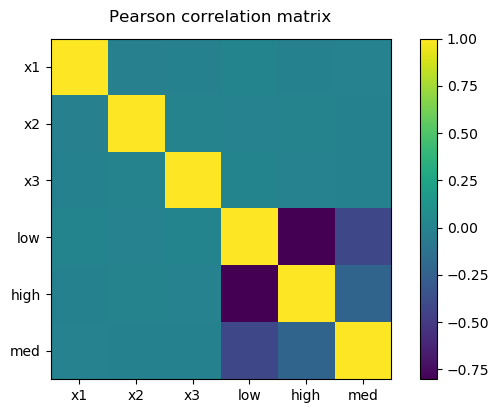

In [76]:
col_names = [x for x in data.columns if not x.startswith('target')]
f, ax = plt.subplots(dpi = 100)
corr = ax.imshow(data.corr())
ax.set_xticks(np.arange(len(col_names)))
ax.set_xticklabels(col_names)
ax.set_yticks(np.arange(len(col_names)))
ax.set_yticklabels(col_names)
f.colorbar(corr)
f.suptitle('Pearson correlation matrix', y = 1.02)
f.tight_layout()

The correlation matrix shows there is no correlation among the variables, this might suggest that the variables are either *artificial* (hand made) or they are the result of some dimensionality reduction process such as PCA.
Also, there appear to be some *mild* correlation between the variables and the (binarized) target values, which in principle may be due to chance, this is, no significant correlation is seen (at first sight).

## Feature Engineering
Since we don't know the nature of the features $(x_1, x_2, x_3)$ it is difficult to perform feature engineering using prior knowledge about the problem in question. For this reason we will construct simple combinations of the given features in hope of gaining predictive power at the time of inference, in particular for generalized linear models.

In [78]:
def augment_features(data):
    '''Creates a new dataframe with more features that are created as simple functions of features in `data`.
    Parameters:
    ----------
    data: pd.DataFrame,
            original data.
    Returns:
    -------
    augmented_data: pd.DataFrame,
            dataset with features created on top of the features in `data`.
    '''
    df = data.copy()
    df['x2+x1-x3'] = df['x2'] + df['x1'] - df['x3']
    df['x2-x3-x1'] = df['x2'] - df['x3'] - df['x1']
    df['x1-x3'] = df['x1'] - df['x3']
    df['x1+x3'] = df['x1'] + df['x3']
    df['x2-x3'] = df['x2'] - df['x3']
    df['x2+x3'] = df['x2'] + df['x3']

    df['x1x1'] = df['x1']**2
    df['x2x2'] = df['x2']**2
    df['x3x3'] = df['x3']**2

    df['x1x2'] = df['x1']*df['x2']
    df['x2x3'] = df['x2']*df['x3']
    df['x3x1'] = df['x3']*df['x1']

    df['x1x2x3'] = df['x1']*df['x2']*df['x3']
    return df

In [79]:
aug_data = augment_features(data)

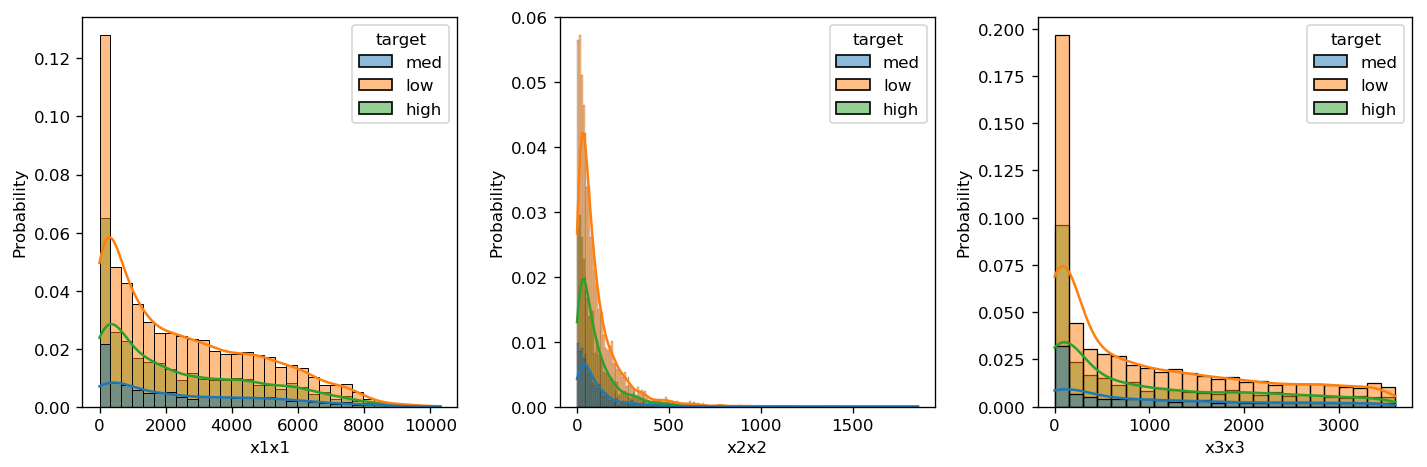

In [83]:
fig, ax = plt.subplots(1,3, dpi =120, figsize = (12,4))
for i in range(3):
    sns.histplot(data = aug_data, x = f'x{i+1}x{i+1}', hue = 'target', 
                 stat= 'probability', ax = ax[i], kde = True)
fig.tight_layout()

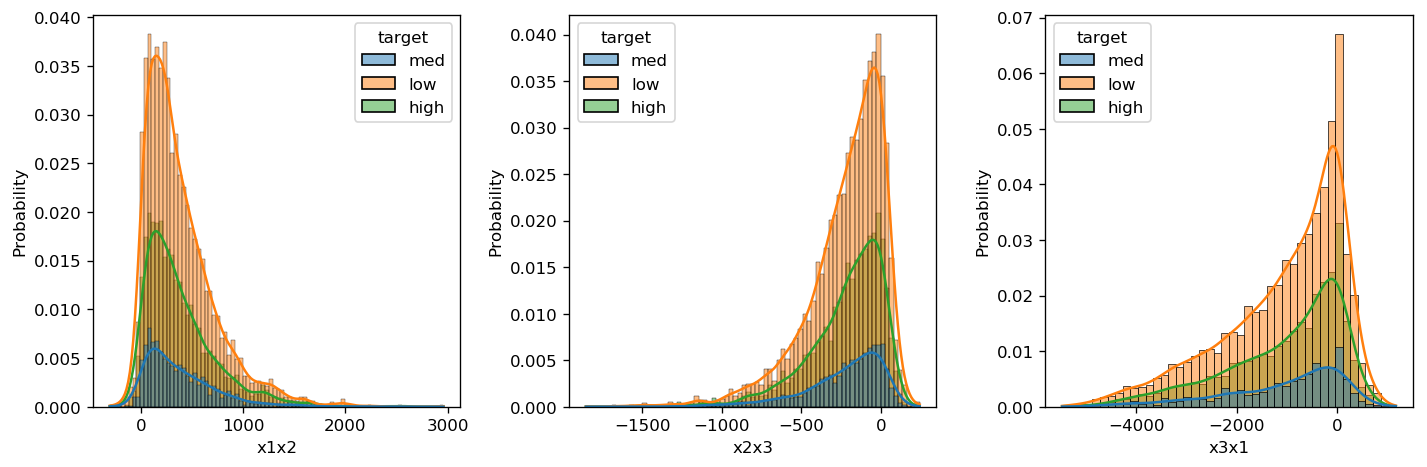

In [84]:
fig, ax = plt.subplots(1,3, dpi =120, figsize = (12,4))
sns.histplot(data = aug_data, x = f'x1x2', hue = 'target', 
             stat= 'probability', ax = ax[0], kde = True)
sns.histplot(data = aug_data, x = f'x2x3', hue = 'target', 
             stat= 'probability', ax = ax[1], kde = True)
sns.histplot(data = aug_data, x = f'x3x1', hue = 'target', 
             stat= 'probability', ax = ax[2], kde = True)
fig.tight_layout()

matplotlib is currently using a non-GUI backend, so cannot show the figure


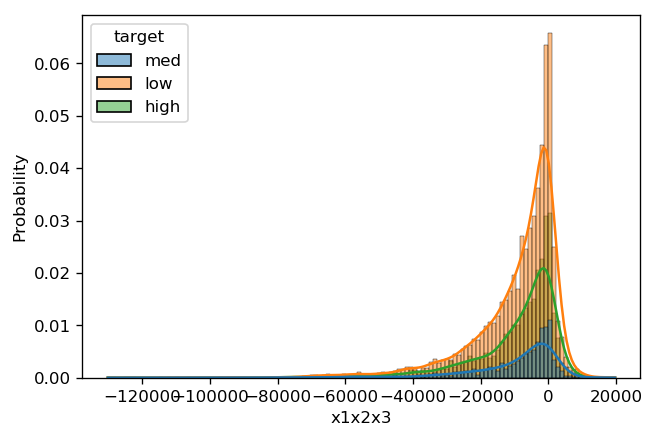

In [85]:
fig, ax = plt.subplots(dpi = 120)
sns.histplot(data= aug_data, x = 'x1x2x3', hue = 'target',
             stat= 'probability', kde = True, ax = ax)
fig.show()

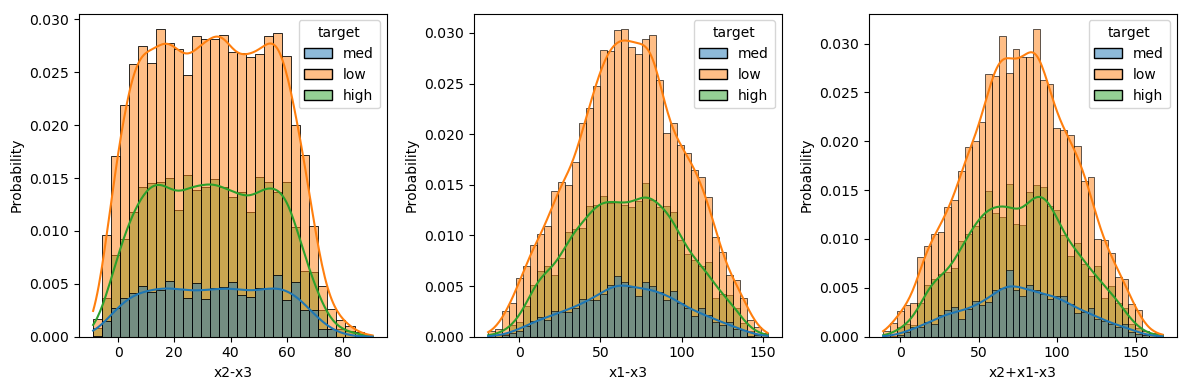

In [86]:
fig, ax = plt.subplots(1,3,dpi = 100, figsize = (12,4))
sns.histplot(aug_data, x = 'x2-x3', hue = 'target',
             stat= 'probability', kde = True, ax = ax[0])
sns.histplot(aug_data, x = 'x1-x3', hue = 'target',
             stat= 'probability', kde = True, ax = ax[1])
sns.histplot(aug_data, x = 'x2+x1-x3', hue = 'target',
             stat= 'probability', kde = True, ax = ax[2])
fig.tight_layout()

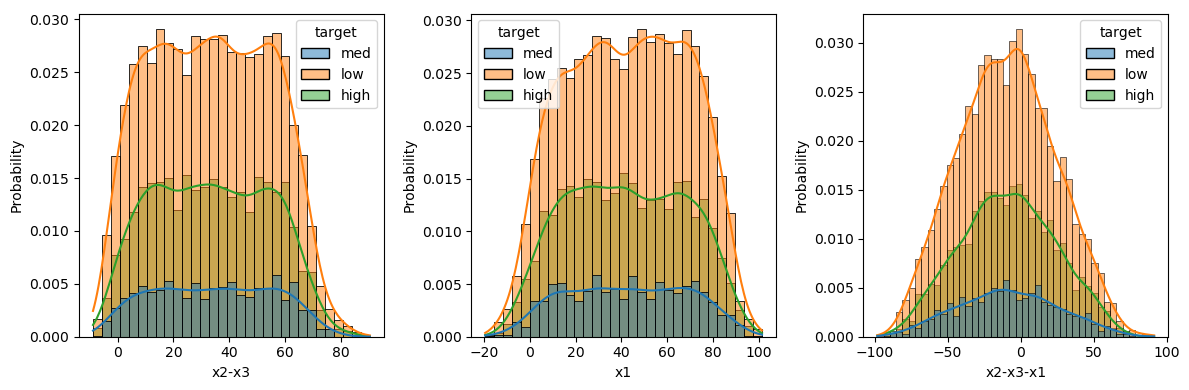

In [87]:
fig, ax = plt.subplots(1,3,dpi = 100, figsize = (12,4))
sns.histplot(aug_data, x = 'x2-x3', hue = 'target',
             stat= 'probability', kde = True, ax = ax[0])
sns.histplot(aug_data, x = 'x1', hue = 'target',
             stat= 'probability', kde = True, ax = ax[1])
sns.histplot(aug_data, x = 'x2-x3-x1', hue = 'target',
             stat= 'probability', kde = True, ax = ax[2])
fig.tight_layout()

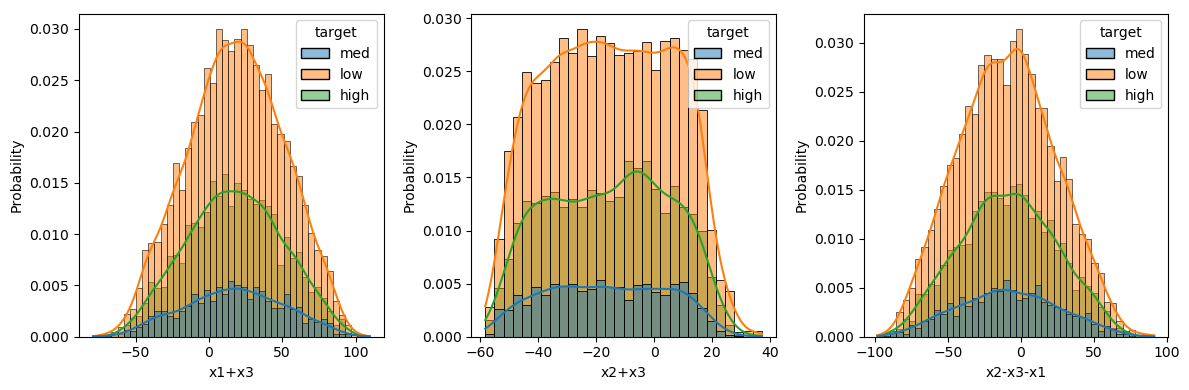

In [88]:
fig, ax = plt.subplots(1,3,dpi = 100, figsize = (12,4))
sns.histplot(aug_data, x = 'x1+x3', hue = 'target',
             stat= 'probability', kde = True, ax = ax[0])
sns.histplot(aug_data, x = 'x2+x3', hue = 'target',
             stat= 'probability', kde = True, ax = ax[1])
sns.histplot(aug_data, x = 'x2-x3-x1', hue = 'target',
             stat= 'probability', kde = True, ax = ax[2])
fig.tight_layout()

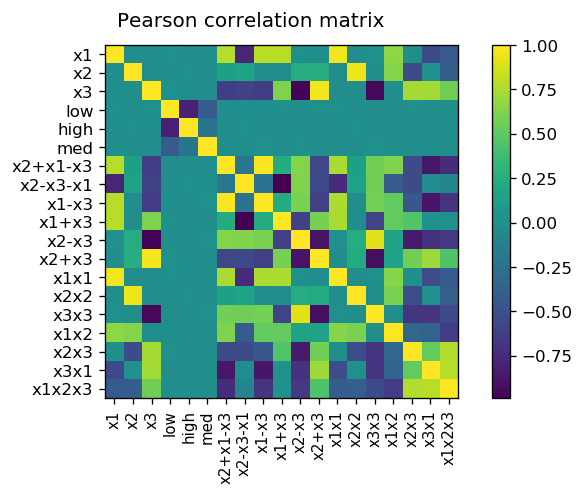

In [98]:
f, ax = plt.subplots(dpi = 120)
aug_corr = ax.imshow(aug_data.corr())
ax.set_xticks(np.arange(aug_data.corr().shape[1]))
ax.set_xticklabels(aug_data.corr().columns, rotation = 90, fontsize = 9)
ax.set_yticks(np.arange(aug_data.corr().shape[1]))
ax.set_yticklabels(aug_data.corr().columns)
f.colorbar(aug_corr)
f.suptitle('Pearson correlation matrix', y = 1.02)
f.tight_layout()

The lack of linear correlation among the (pure and engineered) variables is more evident in the above plot. This could be a problem if trying to make inference of the conditional probability $p(y | \mathbf{x})$ by generalized linear models.

# Modelling

## Problem setup
We can cast the multiclass classification problem in terms of inferring of the conditional probability distribution $p(\mathcal{C}_k | \mathbf{x})$, where $\mathcal{C}_k$ stands for class $k$ and $\mathbf{x}=(x_1, x_2, x_3)$ is a vector whose components are the random variables at hand. In our case we have $\mathcal{C}_1 = \text{low}$, $\mathcal{C}_2 = \text{med}$ and $\mathcal{C}_3 = \text{high}$.

There are two different approaches to infere the conditional probability distribution $p(\mathcal{C}_k | \mathbf{x})$; on one hand we can model the distribution directly by using parametric models and optimizing the parameters using a training set. Alternatively, one could use a generative approach in which the conditional probability $p(\mathbf{x}|\mathcal{C}_k)$ is modeled . Finally Bayes' theorem is used together with the prior probabilities $p(\mathcal{C}_k)$ for the classes to find the required posterior probabilities, namely
$$p(\mathcal{C}_k| \mathbf{x}) = \dfrac{p(\mathbf{x}|\mathcal{C}_k)p(\mathcal{C}_k)}{p(\mathbf{x})}.$$

We will tackle the classifying problem at hand using both approaches. First, we will use a parametric model for the inference of the conditional probability distributions $p(\mathcal{C}_k | \mathbf{x})$. Next, we will use a simple generative model (Naive Bayes) to infere - via the Bayes' theorem- the conditional probability distribution $p(\mathcal{C}_k | \mathbf{x})$.

In the case of multilabel classification, we can follow several strategies in order to reduce the problem into a collection of simpler (binary classification) problems, namely:
 * **One vs All:** where the problem is broken down into a collection of $|\mathcal{C}_k|$ (number of classes) binary classification problems, where each *sub-problem* consists in classifying whether a sample belongs to class $\mathcal{C}_k$ or not.
 * **One vs One:** where the multilabel classification problem is broken into a collection of $|\mathcal{C}_k|(|\mathcal{C}_k|-1)/2$. In this case each sub-problem consist in distinguishing if a sample belongs to class $\mathcal{C}_k$ or to $\mathcal{C}_j$. Clearly (for $k>3$) the number of classifying problems this strategy solves is larger than in the *One vs All* case, however the number of examples used to train the sub-models is smaller. In the end, one has to take into account the complexity of each approach in order to choose the best suited for the problem in question.
 * **Error Correction Codes:** In this setup the target values are enconded as error correction codes (bits) such that the problem now is casted in terms of several classifying models (equal to the number of bits used to encode the target values) whose task is to predict the probability of each bit. In the end, a majority vote could be used to determine the value of each bit and thus determining the final prediction.
 * **Multi-layer perceptrons:** Neural networks can be used to directly estimate the probability of each sample belonging to class $\mathcal{C_k}$ by setting the final layer to have as many sigmoid nodes as there are classes $\mathcal{C}_k$. 

## Logistic Regression (Benchmark)
We use the logistic regression as a benchmark model. The modelling will be performed using the One vs All approach making use of `scikit-learn` machinery. The best parameters are chosen using a `GridSearchCV` and then multilabel metrics are calculated, focusing in the ROC curve and the area under this curve (ROC-AUC). A test set is separated to calculate the *out-of-sample* metrics.

### Pre-processing

In [99]:
random_state = 42

In [130]:
feature_names = [x for x in aug_data.columns if not x.startswith(('target', 'low', 'high', 'med'))]
classes = aug_data['target'].value_counts().index.to_list()

In [131]:
X = aug_data[feature_names]
y = pd.DataFrame(label_binarize(aug_data['target'], classes = classes), columns = classes)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.2, stratify = y,
                                                    random_state = random_state)

### Modelling

In [133]:
# Construct the sklearn pipeline
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('logreg', OneVsRestClassifier(LogisticRegression()))])

# Set the parameter grid for hyperparameter optimization
param_grid = {
    'logreg__estimator__penalty': ['l2', 'elasticnet'],
    'logreg__estimator__C': np.logspace(-4, 4, 8),
    'logreg__estimator__class_weight': ['balanced', None]
        }

In [134]:
%%time
# Optimize
search = GridSearchCV(pipe, param_grid, n_jobs=4)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.600):
{'logreg__estimator__C': 0.0001, 'logreg__estimator__class_weight': None, 'logreg__estimator__penalty': 'l2'}
CPU times: user 570 ms, sys: 77.9 ms, total: 648 ms
Wall time: 4.4 s


In [135]:
%%time
# Choose the best model
logreg_clf = search.best_estimator_

# Predict on test set
y_probas = logreg_clf.predict_proba(X_test)



CPU times: user 80.9 ms, sys: 5.77 ms, total: 86.6 ms
Wall time: 25.3 ms


### Metrics

In [145]:
# Calculate multilabel metrics
fpr, tpr, roc_auc = compute_roc_auc_classes(y_test, y_probas)
precision, recall, average_precision = compute_precision_recall_classes(y_test, y_probas)

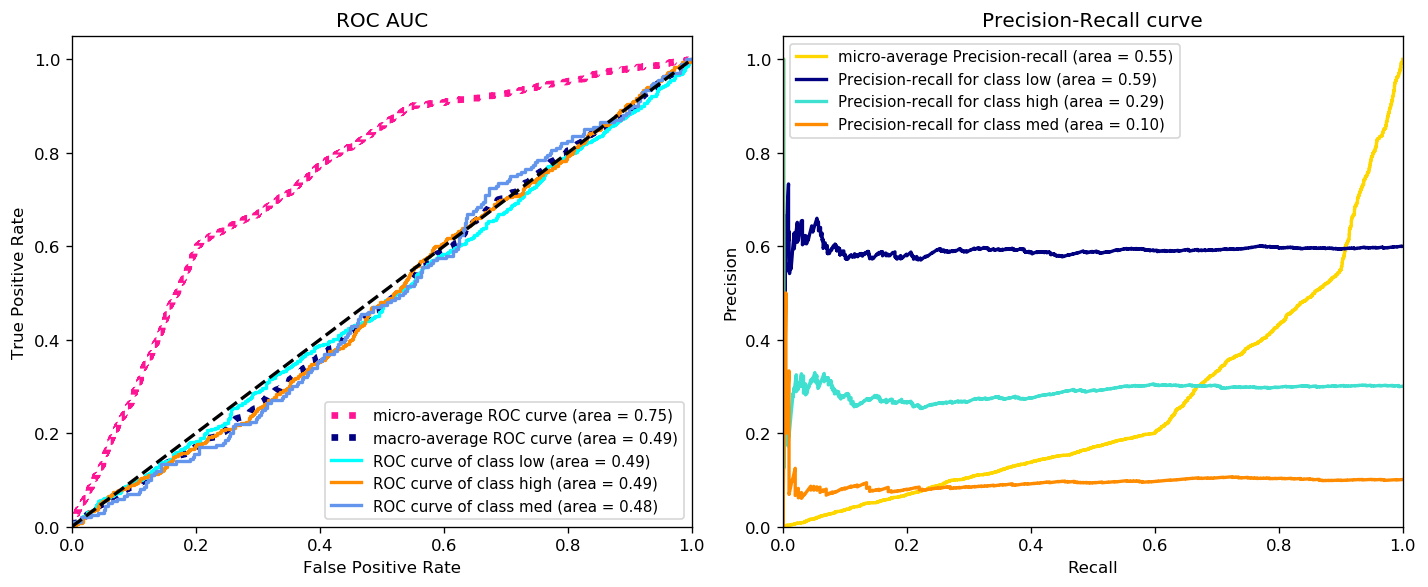

In [156]:
fig, ax = plt.subplots(1,2, dpi = 120, figsize = (12,5))
plot_roc_auc_classes(fpr, tpr, roc_auc, ax = ax[0], fontsize = 9)
plot_precision_recall_curve(precision, recall, average_precision, ax = ax[1], fontsize = 9)
fig.tight_layout()

## XGBoost
In this section we test a non-parametric model. In particular, an ensemble of gradient boostind decision trees. Similiar to the Logistic Regressin case, we use the `sklearn` machinery to embed this model into a **One vs All** setting.

In [ ]:
# Construct the sklearn pipeline
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('xgb', OneVsRestClassifier(XGBClassifier()))])

# Set the parameter grid for hyperparameter optimization
param_grid = {
    'xgb__estimator__penalty': ['l2', 'elasticnet'],
    'xgb__estimator__C': np.logspace(-4, 4, 8),
    'xgb__estimator__class_weight': ['balanced', None]
        }